In [1]:
import pandas as pd
import numpy as np


restaurants_ds = pd.read_csv("restaurants_df.csv")
restaurants_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4343 entries, 0 to 4342
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         4343 non-null   object
 1   Address      4343 non-null   object
 2   P-nummer     4343 non-null   int64 
 3   Startdate    4306 non-null   object
 4   Enddate      188 non-null    object
 5   code         4343 non-null   int64 
 6   active       4343 non-null   bool  
 7   postal_code  4343 non-null   int64 
dtypes: bool(1), int64(3), object(4)
memory usage: 241.9+ KB


In [3]:
population_ds = pd.read_csv("data/population_df.csv")
population_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighborhood_code       474 non-null    int64  
 1   neighborhood_name       474 non-null    object 
 2   postal_code             474 non-null    int64  
 3   postal_area             474 non-null    object 
 4   postal_code_m2          474 non-null    int64  
 5   Total                   474 non-null    int64  
 6   Men                     474 non-null    int64  
 7   Women                   474 non-null    int64  
 8   population_density_km2  471 non-null    float64
 9   restaurant_count        474 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 37.2+ KB


In [4]:
footTraffic_ds = pd.read_csv("data\expanded_foot_trafic.csv")
footTraffic_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7062 entries, 0 to 7061
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latitude       7062 non-null   float64
 1   longitude      7062 non-null   float64
 2   aadt_fod_7_19  7062 non-null   float64
 3   hvdt_fod_7_19  7062 non-null   float64
dtypes: float64(4)
memory usage: 220.8 KB


In [5]:
mapsReviews_ds = pd.read_csv("data/maps_data_scraped.csv")
mapsReviews_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4552 entries, 0 to 4551
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Input Name     4552 non-null   object 
 1   Input Address  4552 non-null   object 
 2   Title          2527 non-null   object 
 3   Rating         2397 non-null   object 
 4   Reviews        2372 non-null   float64
 5   Price Level    920 non-null    object 
 6   Tags           1603 non-null   object 
dtypes: float64(1), object(6)
memory usage: 249.1+ KB


In [6]:
# mapping price level
# Mappatura basata sulla reference che abbiamo deciso
price_mapping = {
    "1-100 kr a persona": 1,
    "1-200 kr a persona": 1,
    "100-200 kr a persona": 1,
    "100-300 kr a persona": 2,
    "200-300 kr a persona": 2,
    "200-400 kr a persona": 2,
    "300-400 kr a persona": 3,
    "300-500 kr a persona": 3,
    "400-500 kr a persona": 3,
    "400-600 kr a persona": 3,
    "500-600 kr a persona": 3,
    "600-700 kr a persona": 4,
    "Più di 1000 kr a persona": 5,
    "2000-4000 kr a persona": 5,
    "1-10 â\x82¬ a persona": 1,  # 7–75 DKK ≈ low
    "30-40 â\x82¬ a persona": 2,  # 224–298 DKK ≈ mid-low
}

# Applichiamo la mappatura
mapsReviews_ds["price_level_mapped"] = mapsReviews_ds["Price Level"].map(price_mapping)

In [7]:
mapsReviews_ds["price_level_missing"] = mapsReviews_ds["price_level_mapped"].isna()
mapsReviews_ds["price_level_mapped"] = mapsReviews_ds["price_level_mapped"].fillna(2)

In [10]:
# Prima assicuriamoci che Rating sia numerico
mapsReviews_ds["Rating"] = pd.to_numeric(mapsReviews_ds["Rating"], errors="coerce")

# Crea flag se manca
mapsReviews_ds["rating_missing"] = mapsReviews_ds["Rating"].isna()

# Riempie NaN con valore medio (3.5)
mapsReviews_ds["Rating"] = mapsReviews_ds["Rating"].fillna(3.5)

In [ ]:
original_ratings = pd.read_csv("data/maps_data_scraped.csv")
original_ratings = original_ratings[["Input Name", "Rating"]]

mapsReviews_ds["Rating"] = mapsReviews_ds.apply(
    lambda row: (
        original_ratings.loc[
            original_ratings["Input Name"] == row["Input Name"], "Rating"
        ].values[0]
        if row["Input Name"] in original_ratings["Input Name"].values
        and not pd.isna(
            original_ratings.loc[
                original_ratings["Input Name"] == row["Input Name"], "Rating"
            ].values[0]
        )
        else row["Rating"]
    ),
    axis=1,
)

In [19]:
# Assicuriamoci che Reviews sia numerico
mapsReviews_ds["Reviews"] = pd.to_numeric(mapsReviews_ds["Reviews"], errors="coerce")

# Riempie NaN con un valore tipo 5 recensioni
mapsReviews_ds["Reviews"] = mapsReviews_ds["Reviews"].fillna(5)

In [20]:
mapsReviews_ds.to_csv("mapsReviews_ds_NoNull.csv", index=False)

# MERGE ALL DATASETS

## Restaurants + Reviews

In [21]:
def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text).lower().strip().replace("  ", " ")


# Puliamo nei due dataset
restaurants_ds["Name_clean"] = restaurants_ds["Name"].apply(clean_text)
restaurants_ds["Address_clean"] = restaurants_ds["Address"].apply(clean_text)

mapsReviews_ds["Input Name_clean"] = mapsReviews_ds["Input Name"].apply(clean_text)
mapsReviews_ds["Input Address_clean"] = mapsReviews_ds["Input Address"].apply(
    clean_text
)

In [32]:
!pip install rapidfuzz

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 145.2 kB/s eta 0:00:12
   - -------------------------------------- 0.1/1.6 MB 328.2 kB/s eta 0:00:05
   - -------------------------------------- 0.1/1.6 MB 328.2 kB/s eta 0:00:05
   - -------------------------------------- 0.1/1.6 MB 231.0 kB/s eta 0:00:07
   ---- ----------------------------------- 0.2/1.6 MB 517.2 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.6 MB 517.2 kB/s eta 0:00:03
   ------ --------------------------------- 0.3/1.6 MB 630.5 kB/s eta 0:00:03
   ------ --------------------------------- 0.3/1.6 MB 587.7 kB/s eta 0:00:03
   -------- ------------------------------- 0.4/1.6 MB 696.3 kB/s eta 0:00:02
   ------------- -----


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [22]:
from rapidfuzz import process

# Creiamo dizionario dei nomi delle review
review_names = mapsReviews_ds["Input Name_clean"].tolist()


def fuzzy_match(name):
    match = process.extractOne(
        name, review_names, score_cutoff=80
    )  # solo se >80% di similarità
    if match:
        return match[0]
    return None


# Applichiamo fuzzy matching
restaurants_ds["matched_name"] = restaurants_ds["Name_clean"].apply(fuzzy_match)

# Poi merge
merged_df = restaurants_ds.merge(
    mapsReviews_ds,
    how="left",
    left_on="matched_name",
    right_on="Input Name_clean",
    suffixes=("", "_review"),
)

In [23]:
# Supponiamo che il dataframe merged si chiami merged_df

# Quanti ristoranti hanno trovato Rating (cioè matchato?)
matched = merged_df["Rating"].notna().sum()

# Quanti ristoranti NON hanno trovato Rating?
unmatched = merged_df["Rating"].isna().sum()

# Quanti ristoranti totali?
total = len(merged_df)

# Percentuali
matched_pct = (matched / total) * 100
unmatched_pct = (unmatched / total) * 100

# Stampa il risultato
print(f"Matched: {matched} ({matched_pct:.2f}%)")
print(f"Unmatched: {unmatched} ({unmatched_pct:.2f}%)")

Matched: 4721 (100.00%)
Unmatched: 0 (0.00%)


## merged_df + population

In [24]:
assert population_ds[
    "postal_code"
].is_unique, "Errore: postal_code duplicati in population_ds"

In [39]:
merged_df = merged_df.merge(
    population_ds[
        ["postal_code", "Total", "population_density_km2", "restaurant_count"]
    ],
    how="left",
    on="postal_code",
    suffixes=("", "_population"),
)

In [40]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721 entries, 0 to 4720
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    4721 non-null   object 
 1   Address                 4721 non-null   object 
 2   P-nummer                4721 non-null   int64  
 3   Startdate               4672 non-null   object 
 4   Enddate                 211 non-null    object 
 5   code                    4721 non-null   int64  
 6   active                  4721 non-null   bool   
 7   postal_code             4721 non-null   int64  
 8   Name_clean              4721 non-null   object 
 9   Address_clean           4721 non-null   object 
 10  matched_name            4721 non-null   object 
 11  Input Name              4721 non-null   object 
 12  Input Address           4721 non-null   object 
 13  Title                   2661 non-null   object 
 14  Rating                  4721 non-null   

## Merged_df + footTraffic

### Postal code to CAP

In [25]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="foot_traffic_matcher")


# Funzione che geocodifica un postal_code
def get_coordinates(postal_code):
    try:
        location = geolocator.geocode(f"{postal_code} Copenhagen Denmark")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None


# Creiamo una nuova tabella con CAP unici
postal_code_unique = merged_df["postal_code"].dropna().unique()

# Geocodifica di tutti i CAP
postal_code_coords = []
for code in postal_code_unique:
    lat, lon = get_coordinates(code)
    postal_code_coords.append((code, lat, lon))
    time.sleep(1)  # importantissimo per non farsi bloccare

postal_coords_df = pd.DataFrame(
    postal_code_coords, columns=["postal_code", "latitude", "longitude"]
)

postal_coords_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   postal_code  308 non-null    int64  
 1   latitude     308 non-null    float64
 2   longitude    308 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.3 KB


In [26]:
print(footTraffic_ds.columns)

Index(['latitude', 'longitude', 'aadt_fod_7_19', 'hvdt_fod_7_19'], dtype='object')


In [27]:
from geopy.distance import geodesic


# Funzione per trovare il foot traffic della stazione più vicina
def find_nearest_traffic(lat, lon, stations_df):
    distances = stations_df.apply(
        lambda row: geodesic((lat, lon), (row["latitude"], row["longitude"])).meters,
        axis=1,
    )
    nearest_idx = distances.idxmin()
    return stations_df.loc[
        nearest_idx, "aadt_fod_7_19"
    ]  # puoi cambiare con 'hvdt_fod_7_19' se vuoi picco


# Applichiamo a tutti i CAP
postal_coords_df["foot_traffic"] = postal_coords_df.apply(
    lambda row: find_nearest_traffic(row["latitude"], row["longitude"], footTraffic_ds),
    axis=1,
)

In [28]:
postal_coords_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   postal_code   308 non-null    int64  
 1   latitude      308 non-null    float64
 2   longitude     308 non-null    float64
 3   foot_traffic  308 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 9.8 KB


In [29]:
# Merge su postal_code
merged_df = merged_df.merge(
    postal_coords_df[["postal_code", "latitude", "longitude", "foot_traffic"]],
    how="left",
    on="postal_code",
)

In [30]:
print(merged_df[["postal_code", "latitude", "longitude", "foot_traffic"]].head())
print(merged_df.shape)

   postal_code   latitude  longitude  foot_traffic
0         2200  55.694915  12.550130   4305.306806
1         2300  55.650905  12.602597   1778.477032
2         2200  55.694915  12.550130   4305.306806
3         3670  55.686724  12.570072   4468.524085
4         1051  55.679985  12.590608  11751.005514
(4721, 26)


### Function to calculate the risk

In [41]:
def hybrid_closure_time(row):
    # --- compute risk as before ---
    try:
        rating = float(row["Rating"])
    except:
        rating = 3.5

    risk = 0
    if rating < 3.5:
        risk += 0.4
    elif rating > 4.2:
        risk += 0.1
    else:
        risk += 0.25

    if row["price_level_mapped"] in [1, 5]:
        risk += 0.15
    try:
        reviews = float(row["Reviews"])
    except:
        reviews = 5
    if reviews < 10:
        risk += 0.1

    if pd.notna(row.get("foot_traffic")) and float(row["foot_traffic"]) < 3000:
        risk += 0.15

    if (
        pd.notna(row.get("population_density_km2"))
        and float(row["population_density_km2"]) < 5000
    ):
        risk += 0.1

    risk = min(risk, 1.0)

    # --- simulate closure ---
    r = np.random.rand()
    if r < 0.6 + 0.3 * risk:
        closure_years = np.random.randint(2, 8)
    elif r < 0.9 + 0.08 * (1 - risk):
        closure_years = np.random.randint(8, 16)
    else:
        closure_years = min(np.random.geometric(0.02), 30)

    return pd.Series({"closure_years": closure_years, "closure_risk": risk})

In [42]:
merged_df[["closure_years", "closure_risk"]] = merged_df.apply(
    hybrid_closure_time, axis=1
)

In [43]:
import numpy as np

np.random.seed(42)  # così risultato ripetibile

# Simuliamo random solo per quelli attivi
mask_open = merged_df["active"] == True
merged_df.loc[mask_open, "random_val"] = np.random.rand(mask_open.sum())

# Decide chi chiude
merged_df["closure_simulated"] = False  # default

merged_df.loc[mask_open, "closure_simulated"] = (
    merged_df.loc[mask_open, "random_val"] < merged_df.loc[mask_open, "closure_risk"]
)

In [44]:
# Converte Startdate in datetime sicuro
merged_df["Startdate"] = pd.to_datetime(merged_df["Startdate"], errors="coerce")

today = pd.to_datetime("today")

# Chiudiamo quelli che devono chiudere
mask_newly_closed = (merged_df["active"] == True) & (
    merged_df["closure_simulated"] == True
)

merged_df.loc[mask_newly_closed, "Simulated_EndDate"] = merged_df.loc[
    mask_newly_closed, "Startdate"
] + pd.to_timedelta(
    np.random.randint(2 * 365, 7 * 365, size=mask_newly_closed.sum()), unit="D"
)

# Aggiorniamo lo stato active
merged_df.loc[mask_newly_closed, "active"] = False
merged_df["Simulated_EndDate"] = pd.to_datetime(merged_df["Simulated_EndDate"])

C:\Users\Dell\AppData\Local\Temp\ipykernel_22044\2866452518.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_df["Startdate"] = pd.to_datetime(merged_df["Startdate"], errors="coerce")


In [45]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721 entries, 0 to 4720
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Name                 4721 non-null   object        
 1   Address              4721 non-null   object        
 2   P-nummer             4721 non-null   int64         
 3   Startdate            4672 non-null   datetime64[ns]
 4   Enddate              211 non-null    object        
 5   code                 4721 non-null   int64         
 6   active               4721 non-null   bool          
 7   postal_code          4721 non-null   int64         
 8   Name_clean           4721 non-null   object        
 9   Address_clean        4721 non-null   object        
 10  matched_name         4721 non-null   object        
 11  Input Name           4721 non-null   object        
 12  Input Address        4721 non-null   object        
 13  Title                2661 non-nul

In [46]:
today = pd.to_datetime("today")

# Calcoliamo la durata:
merged_df["duration_days"] = (
    merged_df["Simulated_EndDate"].fillna(today) - merged_df["Startdate"]
).dt.days

In [47]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721 entries, 0 to 4720
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Name                 4721 non-null   object        
 1   Address              4721 non-null   object        
 2   P-nummer             4721 non-null   int64         
 3   Startdate            4672 non-null   datetime64[ns]
 4   Enddate              211 non-null    object        
 5   code                 4721 non-null   int64         
 6   active               4721 non-null   bool          
 7   postal_code          4721 non-null   int64         
 8   Name_clean           4721 non-null   object        
 9   Address_clean        4721 non-null   object        
 10  matched_name         4721 non-null   object        
 11  Input Name           4721 non-null   object        
 12  Input Address        4721 non-null   object        
 13  Title                2661 non-nul

Text(0.5, 0, 'Durata (giorni)')

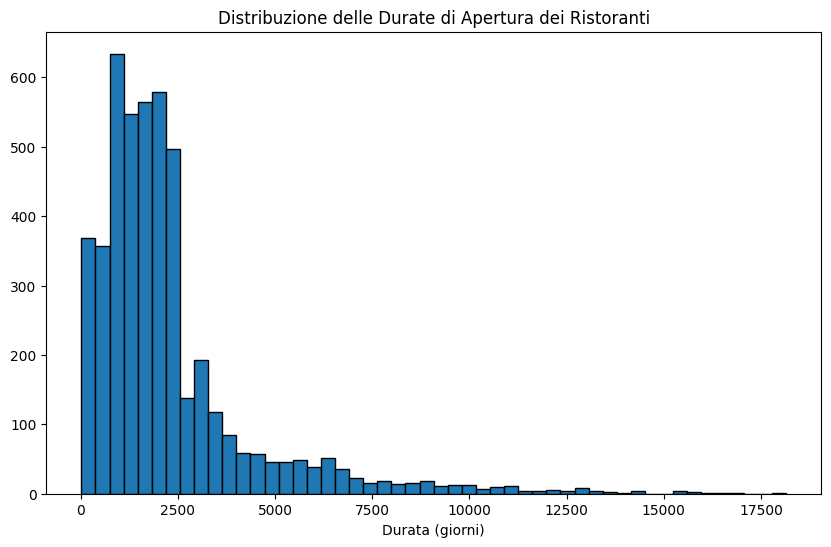

In [48]:
import matplotlib.pyplot as plt

# Pulisci i NaN prima di plottare
duration_clean = merged_df["duration_days"].dropna()

plt.figure(figsize=(10, 6))
plt.hist(duration_clean, bins=50, edgecolor="black")
plt.title("Distribuzione delle Durate di Apertura dei Ristoranti")
plt.xlabel("Durata (giorni)")

In [52]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721 entries, 0 to 4720
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Name                 4721 non-null   object        
 1   Address              4721 non-null   object        
 2   P-nummer             4721 non-null   int64         
 3   Startdate            4672 non-null   datetime64[ns]
 4   Enddate              211 non-null    object        
 5   code                 4721 non-null   int64         
 6   active               4721 non-null   bool          
 7   postal_code          4721 non-null   int64         
 8   Name_clean           4721 non-null   object        
 9   Address_clean        4721 non-null   object        
 10  matched_name         4721 non-null   object        
 11  Input Name           4721 non-null   object        
 12  Input Address        4721 non-null   object        
 13  Title                2661 non-nul

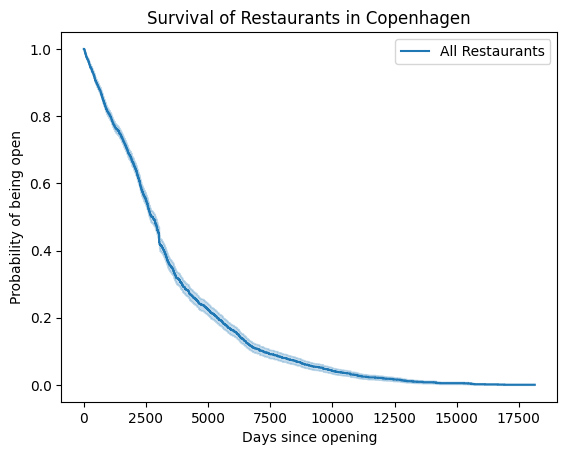

In [53]:
# Filtro solo righe complete
from lifelines import KaplanMeierFitter


kmf_df = merged_df.dropna(subset=["duration_days", "active"])

# Fit sulla versione pulita
kmf = KaplanMeierFitter()
kmf.fit(
    durations=kmf_df["duration_days"],
    event_observed=kmf_df["active"],
    label="All Restaurants",
)
kmf.plot_survival_function()
plt.title("Survival of Restaurants in Copenhagen")
plt.xlabel("Days since opening")
plt.ylabel("Probability of being open")
plt.show()

In [76]:
# Salva il dataframe
merged_df.to_csv("merged_restaurants_final.csv", index=False)

### updated closing endDate

In [78]:
from datetime import datetime
import numpy as np
import pandas as pd

np.random.seed(42)  # Per risultati ripetibili

# 1. Assicuriamoci che Startdate sia in datetime
merged_df["Startdate"] = pd.to_datetime(merged_df["Startdate"], errors="coerce")


# 2. Simuliamo nuove end date solo per i ristoranti già chiusi (active == False)
def simulate_closure_time():
    random_choice = np.random.rand()

    if random_choice < 0.80:
        # 80% chiude tra 2 e 7 anni
        years = np.random.randint(2, 8)
    elif random_choice < 0.95:
        # 15% chiude tra 8 e 15 anni
        years = np.random.randint(8, 16)
    else:
        # 5% sopravvive a lungo
        years = np.random.geometric(0.02)
        years = min(years, 30)  # max 30 anni

    return years


# Maschera per i ristoranti chiusi
mask_closed = merged_df["active"] == False

# Simuliamo nuove chiusure realistiche solo per i già chiusi
simulated_years = [simulate_closure_time() for _ in range(mask_closed.sum())]
simulated_days = [y * 365 for y in simulated_years]

merged_df.loc[mask_closed, "Simulated_EndDate"] = merged_df.loc[
    mask_closed, "Startdate"
] + pd.to_timedelta(simulated_days, unit="D")

# 3. Sistemiamo Enddate (usiamo Simulated_EndDate dove serve)
merged_df["Simulated_EndDate"] = pd.to_datetime(
    merged_df["Simulated_EndDate"], errors="coerce"
)

# 4. Calcoliamo la nuova durata
today = pd.to_datetime("today")
merged_df["duration_days"] = (
    merged_df["Simulated_EndDate"].fillna(today) - merged_df["Startdate"]
).dt.days

# 5. Calcoliamo durata in anni
merged_df["duration_years"] = merged_df["duration_days"] / 365

# 6. Ricalcoliamo lo stato "is_closed"
# (0 = aperto, 1 = chiuso) usando Simulated_EndDate
merged_df["is_closed"] = merged_df["Simulated_EndDate"].notna().astype(int)

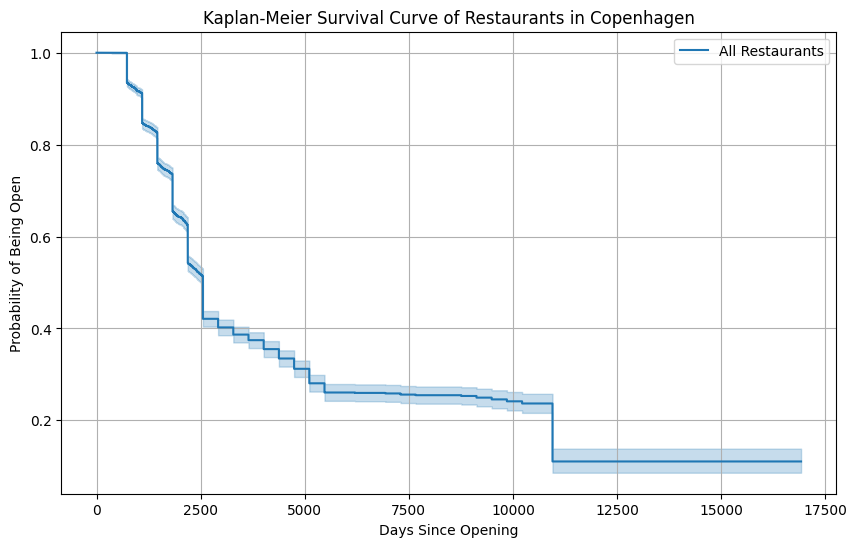

In [79]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Assicurati che non ci siano NaN
kmf_df = merged_df.dropna(subset=["duration_days", "is_closed"])

# Inizializza il Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Fitta il modello
kmf.fit(
    durations=kmf_df["duration_days"],
    event_observed=kmf_df["is_closed"],
    label="All Restaurants",
)

# Plot della funzione di sopravvivenza
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve of Restaurants in Copenhagen")
plt.xlabel("Days Since Opening")
plt.ylabel("Probability of Being Open")
plt.grid(True)
plt.show()

In [2]:
import pandas as pd

merged_df = pd.read_csv("merged_restaurants_final.csv")
# Definiamo "oggi"
today = pd.to_datetime("today")

# Sicurezza: Simulated_EndDate è datetime
merged_df["Simulated_EndDate"] = pd.to_datetime(
    merged_df["Simulated_EndDate"], errors="coerce"
)

# Se la chiusura è futura ➔ resettiamo
mask_future_closures = merged_df["Simulated_EndDate"] > today

# Mettiamo NaT dove la data è futura
merged_df.loc[mask_future_closures, "Simulated_EndDate"] = pd.NaT

# Aggiorniamo anche is_closed
merged_df["is_closed"] = merged_df["Simulated_EndDate"].notna().astype(int)

In [4]:
# Assicuriamoci Startdate sia datetime
merged_df["Startdate"] = pd.to_datetime(merged_df["Startdate"], errors="coerce")

# Ricalcoliamo duration_days
merged_df["duration_days"] = (
    merged_df["Simulated_EndDate"].fillna(today) - merged_df["Startdate"]
).dt.days

# (Opzionale) duration in anni
merged_df["duration_years"] = merged_df["duration_days"] / 365

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4217 entries, 0 to 4700
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Name                    4217 non-null   object        
 1   Address                 4217 non-null   object        
 2   P-nummer                4217 non-null   int64         
 3   Startdate               4187 non-null   datetime64[ns]
 4   Enddate                 164 non-null    object        
 5   code                    4217 non-null   int64         
 6   active                  4217 non-null   bool          
 7   postal_code             4217 non-null   int64         
 8   Name_clean              4217 non-null   object        
 9   Address_clean           4217 non-null   object        
 10  matched_name            4217 non-null   object        
 11  Input Name              4217 non-null   object        
 12  Input Address           4217 non-null   object       

In [10]:
merged_df = merged_df.drop_duplicates("Name")

In [15]:
mapsReviews_df = pd.read_csv("scraping_correct/Datasets/maps_data_scraped.csv")
mapsReviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4552 entries, 0 to 4551
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Input Name     4552 non-null   object 
 1   Input Address  4552 non-null   object 
 2   Title          2527 non-null   object 
 3   Rating         2397 non-null   object 
 4   Reviews        2372 non-null   float64
 5   Price Level    920 non-null    object 
 6   Tags           1603 non-null   object 
dtypes: float64(1), object(6)
memory usage: 249.1+ KB


In [16]:
# Funzione di pulizia nomi
def clean_name(name):
    if pd.isna(name):
        return ""
    return str(name).lower().strip()


# Puliamo i nomi in entrambi i dataset
merged_df["Name_clean"] = merged_df["Name"].apply(clean_name)
mapsReviews_df["Input Name_clean"] = mapsReviews_df["Input Name"].apply(clean_name)

# Creiamo un dizionario dei rating reali
real_ratings = (
    mapsReviews_df.dropna(subset=["Rating"])
    .set_index("Input Name_clean")["Rating"]
    .to_dict()
)


# Funzione per aggiornare i rating
def update_rating(row):
    if row["Name_clean"] in real_ratings:
        return real_ratings[row["Name_clean"]]
    else:
        return row["Rating"]  # se non troviamo, lasciamo quello che c'è


# Applichiamo
merged_df["Rating"] = merged_df.apply(update_rating, axis=1)

# Opzionale: puoi togliere la colonna Name_clean dopo se vuoi
# merged_df.drop(columns=['Name_clean'], inplace=True)

In [17]:
print(merged_df[["Name", "Rating"]].sample(10))

                                    Name Rating
1746                  Pizza Hut Falkoner    3.5
423                       Cafe Høegs ApS    3.5
4501                      baresso coffee    3,6
2500  RIVA PIZZA BURGER & STEAKHOUSE ApS    4,2
2508                 Cafe Emil Valby ApS    3,7
3663                              Fiammi    4,8
1608                  Restaurant Krabben    3.5
426                NKK-HALLENS Cafeteria    3.5
2385            Sushi Joint/Victoria ApS    4,5
877                  INDIAN MAHARAJA ApS    3,8


In [18]:
# Salva il dataframe
merged_df.to_csv("merged_restaurants_final_2.csv", index=False)

In [20]:
scraped_df = pd.read_csv(
    "DELIVERABLE/data/scraped_companies_combined_clean_with_coords.csv"
)
scraped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          4622 non-null   object 
 1   address       4622 non-null   object 
 2   p_nummer      4622 non-null   int64  
 3   status        4622 non-null   object 
 4   company type  4622 non-null   object 
 5   startdate     4566 non-null   object 
 6   enddate       247 non-null    object 
 7   branchekode   4622 non-null   int64  
 8   zip           4622 non-null   int64  
 9   active        4622 non-null   int64  
 10  latitude      4591 non-null   float64
 11  longitude     4591 non-null   float64
dtypes: float64(2), int64(4), object(6)
memory usage: 433.4+ KB


In [21]:
scraped_df = scraped_df.drop_duplicates("name")
scraped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4450 entries, 0 to 4621
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          4450 non-null   object 
 1   address       4450 non-null   object 
 2   p_nummer      4450 non-null   int64  
 3   status        4450 non-null   object 
 4   company type  4450 non-null   object 
 5   startdate     4409 non-null   object 
 6   enddate       192 non-null    object 
 7   branchekode   4450 non-null   int64  
 8   zip           4450 non-null   int64  
 9   active        4450 non-null   int64  
 10  latitude      4423 non-null   float64
 11  longitude     4423 non-null   float64
dtypes: float64(2), int64(4), object(6)
memory usage: 452.0+ KB


In [24]:
merged_df = pd.read_csv("merged_restaurants_final_2.csv")

In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    4217 non-null   object 
 1   Address                 4217 non-null   object 
 2   P-nummer                4217 non-null   int64  
 3   Startdate               4187 non-null   object 
 4   Enddate                 164 non-null    object 
 5   code                    4217 non-null   int64  
 6   active                  4217 non-null   bool   
 7   postal_code             4217 non-null   int64  
 8   Name_clean              4217 non-null   object 
 9   Address_clean           4217 non-null   object 
 10  matched_name            4217 non-null   object 
 11  Input Name              4217 non-null   object 
 12  Input Address           4217 non-null   object 
 13  Title                   2362 non-null   object 
 14  Rating                  4217 non-null   

In [27]:
# Specify the columns you want to keep
columns_to_keep = [
    "Name",
    "Address",
    "Startdate",
    "Simulated_EndDate",
    "code",
    "postal_code",
    "Rating",
    "Reviews",
    "price_level_mapped",
    "duration_days",
]

# Create a new DataFrame with only the selected columns
filtered_df = merged_df[columns_to_keep]

# Display the first few rows of the filtered DataFrame
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                4217 non-null   object 
 1   Address             4217 non-null   object 
 2   Startdate           4187 non-null   object 
 3   Simulated_EndDate   1015 non-null   object 
 4   code                4217 non-null   int64  
 5   postal_code         4217 non-null   int64  
 6   Rating              4217 non-null   float64
 7   Reviews             4217 non-null   float64
 8   price_level_mapped  4217 non-null   int64  
 9   duration_days       4187 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 329.6+ KB
None


In [28]:
def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text).lower().strip()


# Applichiamo la pulizia
filtered_df["Name_clean"] = filtered_df["Name"].apply(clean_text)
filtered_df["Address_clean"] = filtered_df["Address"].apply(clean_text)

scraped_df["name_clean"] = scraped_df["name"].apply(clean_text)
scraped_df["address_clean"] = scraped_df["address"].apply(clean_text)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8860\1886032730.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Name_clean"] = filtered_df["Name"].apply(clean_text)
C:\Users\Dell\AppData\Local\Temp\ipykernel_8860\1886032730.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Address_clean"] = filtered_df["Address"].apply(clean_text)


In [29]:
scraped_df = scraped_df.drop(columns=["company type"], errors="ignore")

In [30]:
from rapidfuzz import process

# Crea chiavi di matching
filtered_df["match_key"] = (
    filtered_df["Name_clean"] + " " + filtered_df["Address_clean"]
)
scraped_df["match_key"] = scraped_df["name_clean"] + " " + scraped_df["address_clean"]

# Lista delle chiavi del dataset di riferimento
scraped_keys = scraped_df["match_key"].tolist()


# Fuzzy match
def fuzzy_match(key):
    match = process.extractOne(key, scraped_keys, score_cutoff=85)
    if match:
        return match[0]  # ritorna la chiave matchata
    else:
        return None


# Applica fuzzy matching
filtered_df["matched_key"] = filtered_df["match_key"].apply(fuzzy_match)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8860\3819219491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["match_key"] = (
C:\Users\Dell\AppData\Local\Temp\ipykernel_8860\3819219491.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["matched_key"] = filtered_df["match_key"].apply(fuzzy_match)


In [31]:
matched = filtered_df["matched_key"].notna().sum()
total = len(filtered_df)
print(f"Match trovati: {matched}/{total} ({matched / total:.1%})")

Match trovati: 4217/4217 (100.0%)


In [32]:
# Usiamo la chiave matched_key per unire i due dataset
merged_df = filtered_df.merge(
    scraped_df,
    how="left",
    left_on="matched_key",
    right_on="match_key",
    suffixes=("", "_scraped"),
)

In [45]:
# Colonne da droppare
columns_to_drop = [
    "Name_clean",
    "Address_clean",
    "matched_key",
    "name_clean",
    "address_clean",
    "match_key",
]

# Drop sicuro
mergedFinal_df = mergedFinal_df.drop(columns=columns_to_drop, errors="ignore")

In [34]:
print(merged_df[["Name", "Address", "latitude", "longitude"]].sample(10))

                                         Name  \
1416                               Pindsvinet   
850   Pizza & Burger House v/Süleyman Arabaci   
3594                      TM Service 2017 ApS   
928                           Italo Disco ApS   
2460                              Food Lab.dk   
1635                           WEDO PIZZA ApS   
678                               Gravenhorst   
2200                Hooked Halgodt Skovshoved   
1024                         A.G Solution ApS   
641                              Åben x Pauli   

                                                Address   latitude  longitude  
1416                  Skovbrynet 2, 2800 Kongens Lyngby  55.766638  12.436325  
850              Roskildevej 211, st., 2620 Albertslund  55.695149  11.728041  
3594                    Vandkunsten 6, 1467 København K  55.676270  12.574264  
928        Oehlenschlægersgade 5, st., 1663 København V  55.672009  12.549898  
2460              Magnoliavej 12, st. tv, 2600 Glostrup  55.

In [49]:
# Lista delle colonne da eliminare
columns_to_drop = [
    "name",
    "address",
    "p_nummer",
    "startdate",
    "enddate",
    "branchekode",
    "zip",
    "active",
    "match_key_scraped",
]

# Droppiamo
mergedFinal_df = mergedFinal_df.drop(columns=columns_to_drop, errors="ignore")

In [ ]:
# Colonne da droppare
columns_to_drop = [
    "name",
    "address",
    "p_nummer",
    "startdate",
    "enddate",
    "branchekode",
    "zip",
    "active",
    "match_key_scraped",
    "Name_clean",
    "Address_clean",
    "matched_key",
    "name_clean",
    "address_clean",
    "match_key",
]

# Drop sicuro
mergedFinal_df = mergedFinal_df.drop(columns=columns_to_drop, errors="ignore")

In [53]:
# Rinomina le colonne in modo ordinato
mergedFinal_df = mergedFinal_df.rename(
    columns={
        "Name": "Restaurant_Name",
        "Address": "Restaurant_Address",
        "Startdate": "Opening_Date",
        "Simulated_EndDate": "Closing_Date",
        "code": "Branchekod",
        "postal_code": "Postal_Code",
        "Rating": "Rating",
        "Reviews": "Number_of_Reviews",
        "price_level_mapped": "Price_Level",
        "duration_days": "Duration_in_Days",
        "status": "Status",
        "latitude": "Latitude",
        "longitude": "Longitude",
    }
)

In [62]:
mergedFinal_df[mergedFinal_df["Opening_Date"].isna()]

,Restaurant_Name,Restaurant_Address,Opening_Date,Closing_Date,Branchekod,Postal_Code,Rating,Number_of_Reviews,Price_Level,Duration_in_Days,Status,Latitude,Longitude


In [60]:
mergedFinal_df = mergedFinal_df.dropna(subset=["Opening_Date"])

In [65]:
# Salva il dataframe
mergedFinal_df.to_csv("mergedFinal_ds.csv", index=False)